In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

tokenizer = AutoTokenizer.from_pretrained("meta-llama/Meta-Llama-3-8B-Instruct")

quant_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_compute_dtype="float16")

model = AutoModelForCausalLM.from_pretrained(
    "meta-llama/Meta-Llama-3-8B-Instruct",
    device_map="auto",
    quantization_config=quant_config,
    torch_dtype="auto"
)



Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
def generate_level():
    # Prepare a chat-style prompt
    prompt = """<|system|>
You are a helpful assistant that generates fun, creative, and playable 2D platformer levels in JSON.

<|user|>
Generate a JSON object representing a level for a 2D platformer game with the following properties:

- Level size: 50 tiles wide and 15 tiles high.
- The bottom 3 tiles (y=1 to y=3) are the ground.
- Holes can only appear in the ground and can be up to 4 tiles wide. No holes allowed in the first 5 tiles of the ground (x=0 to x=4).
- Platforms must be **reachable** by the player:
  - The player can jump up to 4 tiles high.
  - The player can jump up to 4 tiles across.
  - Platforms must be between y=4 and y=12 and not overlap with the ground.
- Platforms should be **spread across the level**, not clustered at the beginning.
- Between 2 and 6 platforms allowed.
- Between 0 and 3 holes allowed.
- The player starts at x=0, so no holes or enemies near that spot.
- The `key`, `exitDoor`, and up to 4 `enemies` must be placed:
  - Only on the ground or on a platform.
  - Not floating.
  - Enemies must be spaced out (not all bunched together).
- The `exitDoor` must be near the right edge (x > 40).
- `difficulty` is an integer from 1 (easy) to 5 (hard).

VERY IMPORTANT: IMAGINE THE PLAYER JUMPING THROUGH THE PLATFORMS

Return **only the JSON object** without explanation or extra text.

Follow this example structure, but generate a new, varied layout each time:

{
  "platforms": [
    { "x": 6, "y": 6, "length": 5 },
    { "x": 20, "y": 8, "length": 4 },
    { "x": 35, "y": 7, "length": 3 }
  ],
  "holes": [
    { "x": 15, "y": 0, "length": 3 }
  ],
  "key": { "x": 36, "y": 8 },
  "enemies": [
    { "x": 10, "y": 3 },
    { "x": 25, "y": 9 }
  ],
  "exitDoor": { "x": 47, "y": 3 },
  "difficulty": 3
}

    <|assistant|>
    """


    # Tokenize and move input to model device
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    # Generate response
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=300,
            temperature=0.8,
            top_p=0.95,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id
        )

    # Decode and print the response
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    # Split on the assistant token
    parts = response.split("<|assistant|>")
    if len(parts) > 1:
        content = parts[1].strip()  # Remove leading/trailing whitespace
        return(content)
    else:
        print("No <|assistant|> token found.")

In [3]:
import matplotlib.pyplot as plt

# ========== DISPLAY ==========

def plot_level(level, title="Generated Level"):
    level_2d = torch.tensor(level).reshape(15, 50)
    plt.figure(figsize=(12, 3))
    plt.imshow(level_2d, cmap="viridis", aspect="auto")
    plt.colorbar()
    plt.title(title)
    plt.show()


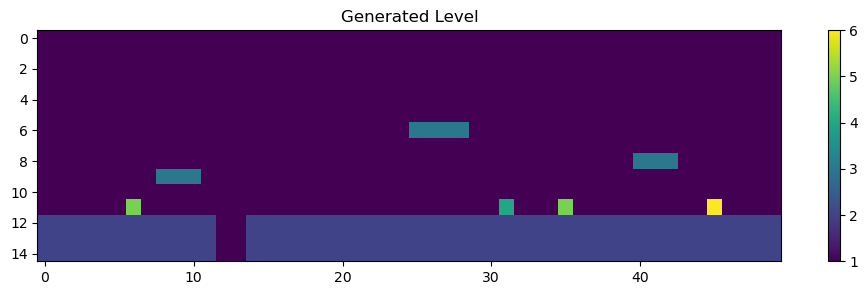

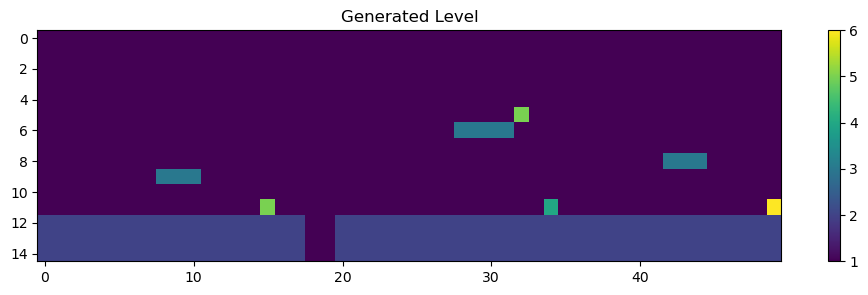

Exception occurred:


Traceback (most recent call last):
  File "C:\Users\AKAI\AppData\Local\Temp\ipykernel_21404\792106444.py", line 15, in <module>
    temp=gl.Json_to_tilemap(level)
         ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\AKAI\OneDrive\master\digital skills\generate_level.py", line 73, in Json_to_tilemap
    tilemap[15-data["exitDoor"]["y"]][data["exitDoor"]["x"]] = 6
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
IndexError: list assignment index out of range


Exception occurred:


Traceback (most recent call last):
  File "C:\Users\AKAI\AppData\Local\Temp\ipykernel_21404\792106444.py", line 15, in <module>
    temp=gl.Json_to_tilemap(level)
         ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\AKAI\OneDrive\master\digital skills\generate_level.py", line 73, in Json_to_tilemap
    tilemap[15-data["exitDoor"]["y"]][data["exitDoor"]["x"]] = 6
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
IndexError: list assignment index out of range


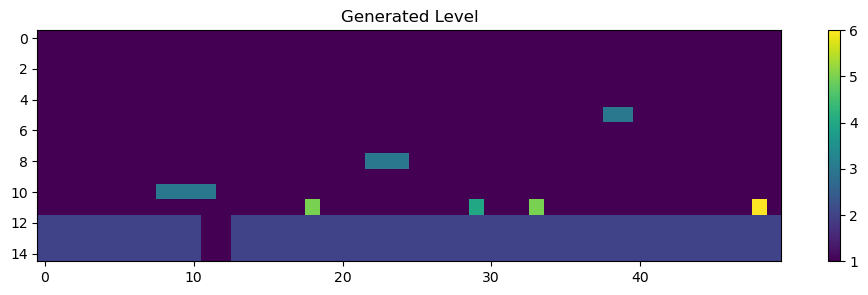

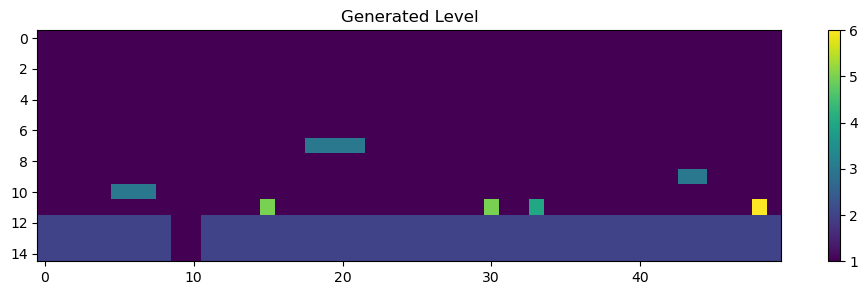

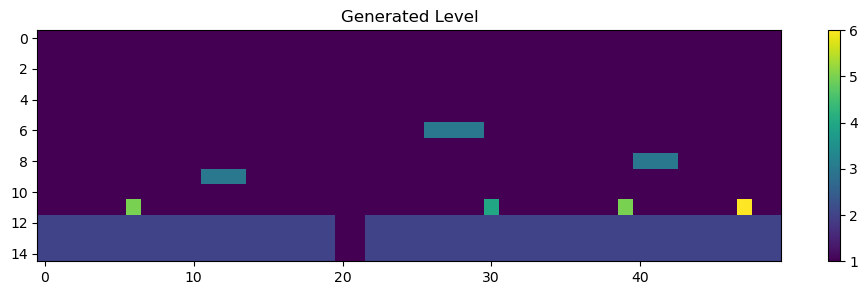

Exception occurred:


Traceback (most recent call last):
  File "C:\Users\AKAI\AppData\Local\Temp\ipykernel_21404\792106444.py", line 12, in <module>
    level=json.loads(level)
          ^^^^^^^^^^^^^^^^^
  File "c:\Users\AKAI\miniconda3\Lib\json\__init__.py", line 346, in loads
    return _default_decoder.decode(s)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\AKAI\miniconda3\Lib\json\decoder.py", line 341, in decode
    raise JSONDecodeError("Extra data", s, end)
json.decoder.JSONDecodeError: Extra data: line 20 column 5 (char 390)


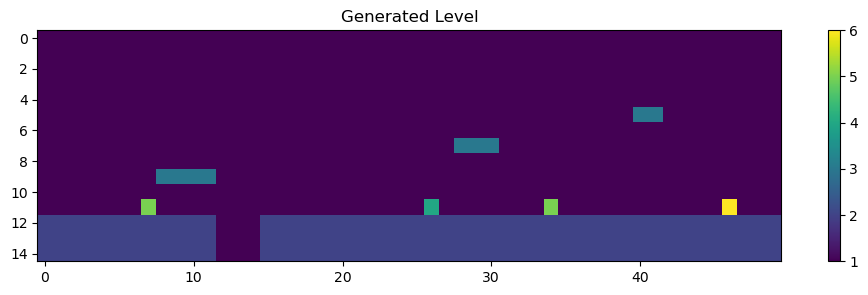

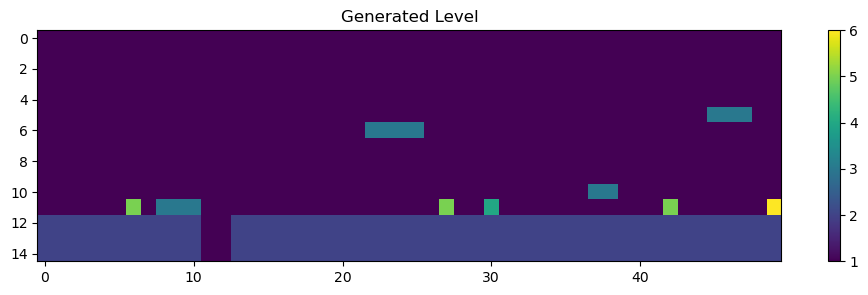

{"platforms": [{"x": 8, "y": 4, "length": 3}, {"x": 22, "y": 9, "length": 4}, {"x": 37, "y": 5, "length": 2}, {"x": 45, "y": 10, "length": 3}], "holes": [{"x": 11, "y": 0, "length": 2}], "key": {"x": 30, "y": 4}, "enemies": [{"x": 5, "y": 4}, {"x": 26, "y": 4}, {"x": 41, "y": 4}], "exitDoor": {"x": 49, "y": 4}, "difficulty": 4}


In [4]:
import verifyLevel as vf
import json
import generate_level as gl
import traceback

status=False
limit=0

while(status == False and limit < 10):
    level=generate_level()
    try:
        level=json.loads(level)
        status=vf.checkPlatforms(level)
        level=vf.fixLevelItems(level)
        temp=gl.Json_to_tilemap(level)
        temp = [int(x) for x in temp if x.strip().isdigit()]
        plot_level(temp)

    except Exception as e:
        print("Exception occurred:")
        traceback.print_exc()
    limit+=1

output=str(level)
output = output.replace("'", '"')
print(output)